## Технологии глубокого обучения и нейронных сетей, МТУСИ

## Лабораторная работа 1: Обучение однослойного персептрона методом коррекции по ошибке через дельта-правило

__Студент:__ Спивак А.А.

__Группа:__ МБД2032

### Цель работы. 

    Изучить алгоритм обучения однослойного персептрона методом коррекции по ошибке через дельта-правило.


### Задание

    В соответствии с вариантом, необходимо обучить нейронную сеть распознавать указанные 4 символа. На каждый символ необходимо подготовить 4 обучающих образа с использованием разных шрифтов. Соответственно, всего будет 16 обучающих образов: 4 образа первым шрифтом, 4 образа, вторым шрифтом и т.д. Тестовая выборка должна содержать по 1 образу на каждый из 4-х символов. Символы должны быть написаны другим шрифтом, который не был использован в обучающей выборке. 

### Теоретические сведения

    Обучение сети включает в себя передачу данных через сеть, использование функции потерь для определения разности между прогнозом и фактической маркировкой, а затем использование этой информации для обновления весов сети, чтобы возврат функции потерь был как можно меньше. Для выполнения обновлений в нейронной сети мы используем оптимизатор.

        Ошибкой выхода персептрона:

$$ e_j=d_j-y_j $$



    Дельта-правило — метод обучения перцептрона по принципу градиентного спуска по поверхности ошибки. Его дальнейшее развитие привело к созданию метода обратного распространения ошибки.

    Вес входного сигнала нейрона изменяется в сторону уменьшения ошибки пропорционально величине суммарной ошибки нейрона. Часто вводят коэффициент пропорциональности $\eta$ , на который умножается величина ошибки. Этот коэффициент называют скоростью или нормой  обучения. 
    
        Формула для корректировки весов:

$$ w_{j}(t+1)=w_{j}(t)+\eta * e_{j} *x_{j}, $$


   где $\eta$ -коэффициент пропорциональности(называют скоростью или нормой  обучения), 

   $e_{j}$ - величина ошибки 

1. Импорт библиотек
2. Загрузчик данных и наборы данных
3. Создание однослойной нейронной сети 
4. Уравнение для обучения
5. Функция потерь (коррекция по ошибке черех дельта правило )
6. Оцениваем точность 

In [59]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch

In [60]:
import numpy as np

In [61]:
path_test = './data/test'
path_train = './data/train'

transforms = transforms.Compose([
    transforms.ToTensor()
])

### Создание загрузчика датасета 

In [62]:
train_dataset = ImageFolder(root = path_test, transform = transforms)
test_dataset = ImageFolder(root = path_train, transform = transforms)

In [63]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

In [64]:
train_loader

### Однослойный персептрон

In [73]:

class NeuralNet:
    
    """ 
    Нейронная сеть прямого распрастронения / классификатор 
    на основе многослойного персептрона
    Параметры:
    ---------
    n_hidden : int (по умолчанию: 30)
        количестов скрытых элементов
    l2: float (по умолчанию: 0.)
        значения лямбда для регулярщации L2
        Регуляризация отстутствует, если l2=0 (принято по умолчанию).
    epochs: int (по умолчанию: 100)
        Количетсов проходов по обучающему набору.
    lr: float (по умолчанию: 0.001)
        скорость обучения 
    shuffle: bool (по умолчанию True)
        Eсли True, тогда обучающие данные тасуются 
        каждую эпоху, чтобы предотвратить циклы
    minibatch_size: int (по умолчанию 1)
        Количество обучаюших образцов на минипакет
    seed : int (по умолчанию:None)
        Случайное начальное значение для инициализации весов и тасования
        
    Атрибуты:
    --------
    eval_ : dict
        Словарь, в котором собираются показатели издержек,
        правильности при обучении и правильности при испытании
        для каждой эпохи во время обучения.
    """
    
    def __init__(self, num_features, num_labels,  num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes
        self.num_labels = num_labels
        
        # output layer инициализация весов для  слоя + баес
        rgen = np.random.RandomState(random_seed)
        
        ### 784, 6
        self.weight_o = rgen.normal(loc = 0.0, scale = 0.001, size = (num_features, num_classes))
        
        ### 1,6
        self.bias_o = np.zeros(num_classes)


    def normalize(self, full_volume):
        mu = full_volume.mean()
        std = np.std(full_volume)
        normalized = (full_volume - mu) / std
        return normalized

    def standardize(self, normalized_data):
        standardized_data = (normalized_data - normalized_data.min()) / (normalized_data.max() - normalized_data.min())
        return standardized_data

    
    def sigmoid(self, z):
        return 1. / (1. + np.exp(-z))
    
    def int_to_onehot(self, y, num_labels):
        
        ''' 
        Кодирует метки класса в представление с унитарным кодом
        
        Параметры:
        ---------
        y: массив, форма = [n_examples]
            Целеые значения.
            
        Возвращает:
        ----------
        onehot : массив, форма = (n_examples, n_labels)
        '''
        ## 1,6: [1,0,0,0,0,0] ---[0,1,0,0,0,0]
        onehot = np.zeros((y.shape[0], num_labels))
        for indx, val in enumerate(y):
            onehot[indx, val] = 1

        return onehot 
    
    def forward(self, X):
        
        ## X: {3, 784}  *   weight_o: {784,6}  +  bias_o:{1,6}  = {3,6}
        # 1 шаг прямого распространение скларяное произведение X и weight_h
        z_out = np.dot(X, self.weight_o) + self.bias_o
        
        # превращает в меньше единицы
        # 2 шаг применение функции активации (сигмоиды) - активация слоя
        a_out = self.sigmoid(z_out)
        
        return  z_out, a_out
    

In [78]:
model = NeuralNet(num_features = 28 * 28,
                      num_labels = 6,
                      num_classes = 6)

In [79]:
def compute_mse_and_acc(nnet, X, y, num_labels = 6 ):
    mse, correct_pred, num_examples = 0., 0, 0


    _, probas = nnet.forward(X)
    predicted_labels = np.argmax(probas, axis=1)

    onehot_targets = int_to_onehot(y, num_labels = num_labels)
    loss = np.mean((onehot_targets - probas) ** 2)
    correct_pred += (predicted_labels == y).sum()

    num_examples += y.shape[0]
    mse += loss

    mse = mse
    acc = correct_pred/num_examples
    return mse, acc

### Обучение 

In [88]:
def train(model, train_loader, valid_loader,  num_epochs, learning_rate=0.1):
    epoch_loss = []
    _loss = []
    
    epoch_train_acc = []
    _train_acc = []
    
    epoch_valid_acc = []
    _valid_acc = []
    
    for e in range(num_epochs):


        
        for X_train_mini, y_train_mini in train_loader:
            
            ### preprocesing
            
            ##сплющивание тензора 3,28,28 --> 3.784
            X_train_mini = torch.flatten(X_train_mini, start_dim = 2, end_dim = 3)
            
            ## меням тип на np.array 3, 785,1 
            X_train_mini = np.array(X_train_mini) 
            
            ## убиарем ось описывабщший батч
            X_train_mini = np.squeeze(X_train_mini)
            
            # перемещавем ось
            #X_train_mini = X_train_mini.swapaxes(0,2) 
            #print(X_train_mini .shape)
            #стандартизируем данные
            X_train_mini = model.standardize(model.normalize(X_train_mini))

            
            y_train_mini = np.array(y_train_mini)
            #print(y_train_mini)


            #### Compute outputs ####
            z_out, a_out = model.forward(X_train_mini)
            #print("a_out", a_out)
            
            #### Compute delta ####
            onehot_target = model.int_to_onehot(y_train_mini, num_labels = 6)
            #print('onehot_target', onehot_target)
            
            delta = (onehot_target  - a_out ) * learning_rate
            #print('delta', delta)
            
            delta_weight = np.dot(delta.T, X_train_mini )
            #print('delta_weight', delta_weight)

            #### Update weights ####
            model.weight_o +=  delta_weight.T
            #print('weight_o', model.weight_o)

            model.bias_o += np.sum(delta, axis = 0)
            #print('bias_o', model.bias_o)
            
            ##loss
            predicted_labels = np.argmax(a_out, axis = 1)
            train_acc = (y_train_mini == predicted_labels)

            train_mse =  ((onehot_target - a_out) ** 2)
            
            _train_acc.append(train_acc)
            _loss.append(train_mse)
            
        for X_valid_mini, y_valid_mini in valid_loader:
            
            ##сплющивание тензора 3,28,28 --> 3.784
            X_valid_mini = torch.flatten(X_valid_mini, start_dim=2, end_dim=3)
            
            ## меням тип на np.array 3, 785,1 
            X_valid_mini = np.array(X_valid_mini) 
            
            ## убиарем ось описывабщший батч
            X_valid_mini = np.squeeze(X_valid_mini)
            
            # перемещавем ось
            #X_train_mini = X_train_mini.swapaxes(0,2) 

            
            #стандартизируем данные
            X_valid_mini = model.standardize(model.normalize(X_valid_mini))

            y_valid_mini = np.array(y_valid_mini)

            
            ##loss
            
            #### Compute outputs ####
            _, a_v_out = model.forward(X_valid_mini)
            
            predicted_labels = np.argmax(a_v_out, axis = 1)
            
            
            valid_acc = (y_valid_mini == predicted_labels)
            _valid_acc.append(valid_acc)

            
        #### Epoch Logging ####        
        #train_mse, train_acc = compute_mse_and_acc(model, X_train_mini, y_train_mini)
        #valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        
        
        train_acc = np.mean(_train_acc) * 100
        train_mse = np.mean(_loss)
        
        valid_acc = np.mean(_valid_acc) * 100
        

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e + 1:03d}/{num_epochs:.2f} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [89]:
np.random.seed(647) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, train_loader, test_loader, num_epochs = 100, learning_rate = 0.01)

Epoch: 001/100.00 | Train MSE: 0.21 | Train Acc: 0.00% | Valid Acc: 79.17%
Epoch: 002/100.00 | Train MSE: 0.15 | Train Acc: 33.33% | Valid Acc: 87.50%
Epoch: 003/100.00 | Train MSE: 0.12 | Train Acc: 55.56% | Valid Acc: 91.67%
Epoch: 004/100.00 | Train MSE: 0.09 | Train Acc: 66.67% | Valid Acc: 93.75%
Epoch: 005/100.00 | Train MSE: 0.08 | Train Acc: 73.33% | Valid Acc: 95.00%
Epoch: 006/100.00 | Train MSE: 0.07 | Train Acc: 77.78% | Valid Acc: 95.83%
Epoch: 007/100.00 | Train MSE: 0.06 | Train Acc: 80.95% | Valid Acc: 96.43%
Epoch: 008/100.00 | Train MSE: 0.05 | Train Acc: 83.33% | Valid Acc: 96.88%
Epoch: 009/100.00 | Train MSE: 0.05 | Train Acc: 85.19% | Valid Acc: 97.22%
Epoch: 010/100.00 | Train MSE: 0.04 | Train Acc: 86.67% | Valid Acc: 97.50%
Epoch: 011/100.00 | Train MSE: 0.04 | Train Acc: 87.88% | Valid Acc: 97.73%
Epoch: 012/100.00 | Train MSE: 0.04 | Train Acc: 88.89% | Valid Acc: 97.92%
Epoch: 013/100.00 | Train MSE: 0.03 | Train Acc: 89.74% | Valid Acc: 98.08%
Epoch: 014/10

In [90]:
model.weight_o

array([[-1.08563060e-03,  9.97345447e-04,  2.82978498e-04,
        -1.50629471e-03, -5.78600252e-04,  1.65143654e-03],
       [-2.42667924e-03, -4.28912629e-04,  1.26593626e-03,
        -8.66740402e-04, -6.78886152e-04, -9.47089689e-05],
       [ 1.49138963e-03, -6.38901997e-04, -4.43981960e-04,
        -4.34351276e-04,  2.20593008e-03,  2.18678609e-03],
       ...,
       [-4.54652365e-04,  2.47005806e-05, -2.05011003e-03,
         6.39761168e-04,  1.42078645e-03,  1.24663078e-03],
       [-1.04379345e-03,  5.98483986e-04,  5.16285804e-05,
        -6.19840380e-04,  5.24523253e-04,  6.66086969e-04],
       [ 4.48142609e-04,  4.94382376e-04, -9.34362341e-05,
         1.65065342e-03, -8.45004127e-04,  3.95839030e-04]])

### Оценка производительности

In [91]:
import matplotlib.pyplot as plt

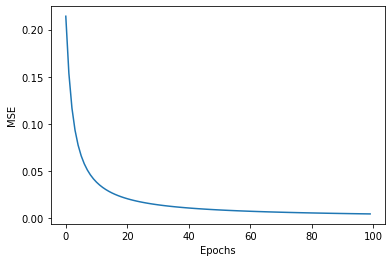

In [92]:
plt.plot(range(len(epoch_loss)), epoch_loss)

plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.show()

### Вывод:

    Наибольший прирост точности обучения проявляется в первых 10 эпохах, далее схождение замедляется. На 100 эпохе все еще происходит небольшой спад, по этому при продолжении обучения точность может стать еще больше.

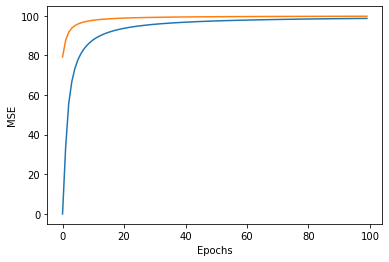

In [93]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc)
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc)
plt.xlabel('Epochs')
plt.ylabel('MSE')

plt.show()

### Вывод:

    В итоге схождение обучения и проверки достигается увеличением числа эпох. 
    На 89 эпохе обучение можно считать завершенным.



## Лабораторная работа 2: Обучение однослойного персептрона методом стохастического градиентного спуска

__Студент:__ Спивак А.А.

__Группа:__ МБД2032


### Цель работы. 

    Изучить алгоритм обучения однослойного персептрона методом стохастического градиентного спуска.


### Задание

    Построить и обучить нейронную сеть для распознавания цифровых рукописных символов из базы данных MNIST (Mixed National Institute of Standards and Technology database). Нейронная сеть должна корректно распознавать образы из тестовой выборки в большинстве случаев. Общий процент ошибки распознавания образов не должен быть выше 20%.

### Теоретические сведения. 

Критерии останова алгоритма обучения могут быть следующими:

* Значение ошибки ε для текущего обучающего вектора, вычисляемое на текущем случайно взятом обучающем векторе не превышает заданного заранее установленного порогового значения εпорог, близкого к нулю: ε<ε_порог.
* Превышен установленный лимит количества эпох.
* Значение общей ошибки всей сети меняется незначительно на протяжении нескольких эпох.


### Ход выполнения работы

### Загрузка предподготовленных данных

In [95]:
mnist = np.load('mnist_scaled.npz')

In [96]:
mnist.files

['X_train', 'y_train', 'X_test', 'y_test', 'X_valid', 'y_valid']

In [97]:
X_train, y_train, X_test, y_test, X_valid, y_valid = [mnist[f] for f in mnist.files]

In [98]:
type(X_train), X_train.shape

(numpy.ndarray, (55000, 784))

In [99]:
import numpy as np

In [100]:

class NeuralNetMLP:
    
    """ 
    Нейронная сеть прямого распрастронения / классификатор 
    на основе многослойного персептрона
    Параметры:
    ---------
    n_hidden : int (по умолчанию: 30)
        количестов скрытых элементов
    l2: float (по умолчанию: 0.)
        значения лямбда для регулярщации L2
        Регуляризация отстутствует, если l2=0 (принято по умолчанию).
    epochs: int (по умолчанию: 100)
        Количетсов проходов по обучающему набору.
    lr: float (по умолчанию: 0.001)
        скорость обучения 
    shuffle: bool (по умолчанию True)
        Eсли True, тогда обучающие данные тасуются 
        каждую эпоху, чтобы предотвратить циклы
    minibatch_size: int (по умолчанию 1)
        Количество обучаюших образцов на минипакет
    seed : int (по умолчанию:None)
        Случайное начальное значение для инициализации весов и тасования
        
    Атрибуты:
    --------
    eval_ : dict
        Словарь, в котором собираются показатели издержек,
        правильности при обучении и правильности при испытании
        для каждой эпохи во время обучения.
    """
    
    def __init__(self, num_features, num_labels,  num_classes, random_seed = 123):
        super().__init__()

        self.num_classes = num_classes
        self.num_labels = num_labels
        
        # output layer инициализация весов для  слоя + баес
        rgen = np.random.RandomState(random_seed)
        self.weight_o = rgen.normal(loc = 0.0, scale = 0.001, size = ( num_classes,num_features ))
        self.bias_o = np.zeros(self.num_classes)



    
    def sigmoid(self, z):
        return 1. / (1. + np.exp(-z))
    
    def int_to_onehot(self, y, num_labels):
        
        ''' 
        Кодирует метки класса в представление с унитарным кодом
        
        Параметры:
        ---------
        y: массив, форма = [n_examples]
            Целеые значения.
            
        Возвращает:
        ----------
        onehot : массив, форма = (n_examples, n_labels)
        '''
        onehot = np.zeros((y.shape[0], num_labels))
        for indx, val in enumerate(y):
            onehot[indx, val] = 1

        return onehot 
    def forward(self, X):
        
        # 1 шаг прямого распространение скларяное произведение X и weight_h
        z_out = np.dot(X, self.weight_o.T) + self.bias_o
        
        # 2 шаг применение функции активации (сигмоиды) - активация слоя
        a_out = self.sigmoid(z_out)
        
        
        return  X, a_out
    
    
    def backward(self, x, a_out, y):
        
        ##########################
        #Обратоне распространение#
        ##########################
        #########################
        ### Output layer weights#
        #########################
        
        #onehot encoding
        y_onehot = self.int_to_onehot(y, self.num_classes)
        
        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct(a_out) * dOutAct(a_out)/dOutNet(z_out) * dOutNet(z_out)/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = x
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis = 0)
        

        return d_loss__dw_out, d_loss__db_out
                
        
        

In [101]:
model = NeuralNetMLP(num_features = 28 * 28,
                     num_labels = 10,
                   num_classes = 10)



In [102]:
minibatch_size=100
num_epochs =50

def minibatch_generator(X, y, minibacth_size=50):
    indices = np.arange(X.shape[0])
    
    
    np.random.shuffle(indices)
     
    #итерация по мини-пакетам
    for start_batch_indx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        indx = indices[start_batch_indx: start_batch_indx + minibatch_size]
        yield X[indx], y[indx]
        
        

        

In [103]:
def compute_mse_and_acc(nnet, X, y, num_labels = 10, minibatch_size = 100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis = 1)
        
        onehot_targets = nnet.int_to_onehot(targets, num_labels = num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [104]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 10.2%


In [105]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    
    
    ''' 
    Обновляем веса 
    
    '''
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            _, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out = \
                model.backward(X_train_mini, a_out, y_train_mini)

            #### Update weights ####
            model.weight_o -= learning_rate * d_loss__d_w_out
            model.bias_o -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [106]:
np.random.seed(647) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs = 60, learning_rate = 0.1)

Epoch: 001/060 | Train MSE: 0.09 | Train Acc: 11.94% | Valid Acc: 12.02%
Epoch: 002/060 | Train MSE: 0.08 | Train Acc: 29.09% | Valid Acc: 29.16%
Epoch: 003/060 | Train MSE: 0.06 | Train Acc: 46.94% | Valid Acc: 47.22%
Epoch: 004/060 | Train MSE: 0.06 | Train Acc: 47.13% | Valid Acc: 47.26%
Epoch: 005/060 | Train MSE: 0.05 | Train Acc: 55.43% | Valid Acc: 55.52%
Epoch: 006/060 | Train MSE: 0.05 | Train Acc: 55.94% | Valid Acc: 56.12%
Epoch: 007/060 | Train MSE: 0.04 | Train Acc: 71.48% | Valid Acc: 71.38%
Epoch: 008/060 | Train MSE: 0.04 | Train Acc: 71.77% | Valid Acc: 71.92%
Epoch: 009/060 | Train MSE: 0.04 | Train Acc: 71.84% | Valid Acc: 71.94%
Epoch: 010/060 | Train MSE: 0.04 | Train Acc: 77.83% | Valid Acc: 77.40%
Epoch: 011/060 | Train MSE: 0.02 | Train Acc: 90.55% | Valid Acc: 90.24%
Epoch: 012/060 | Train MSE: 0.02 | Train Acc: 90.80% | Valid Acc: 90.30%
Epoch: 013/060 | Train MSE: 0.02 | Train Acc: 90.83% | Valid Acc: 90.32%
Epoch: 014/060 | Train MSE: 0.02 | Train Acc: 91.03

In [107]:
import matplotlib.pyplot as plt


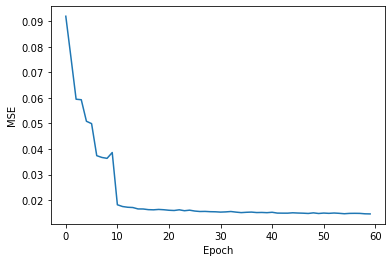

In [108]:
plt.plot(range(len(epoch_loss)), epoch_loss)

plt.xlabel("Epoch")
plt.ylabel("MSE")

plt.show()

### Вывод:

    Наибольший прирост точности обучения проявляется в первых 11 эпохах, далее схождение сильно замедляется. На 60 эпохе спада не наблюдается, по этому обучение можно считать законченным.

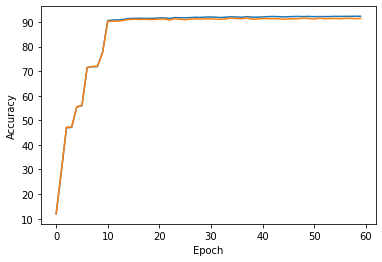

In [109]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc)
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

### Вывод:

    В итоге схождение обучения и проверки достигается увеличением числа эпох. 
    На 59 эпохе обучение можно считать завершенным.

### Итог:
    
    Для правильного обучение нейронной сети стоит обращать внимание на сходимость обучения с тестовыми значениями. Это позволяет судить о том справляется ли нейронная сеть с обучением или стоит подкорректировать модели для обучения или параметры сети.